# Analyze Region 12 - Caucasus and Middle East

This notebook analyzes the largest glaciers in Region 12 - Caucasus and Middle East

In [1]:
import os
import os.path as op
import glob
import sys
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "12"
region_name = "Caucasus and Middle East"

# 3/5/22 - This variable has been deemed unnecessary for this data set so it has been commented out
# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
#primeclass = 5 # These are in mountains but also could be valley glaciers. The literature calls them valley glaciers.

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 11
region_index_2 = 12

# Ice cap/icefield epsg code used for calculating area
#ic_epsg = '102025'

# This variable sets a value to determine whether the differences between the GLIMS and RGI glacier have been checked.
# When first starting a new notebook set handled to 0
# Once the differences have been checked and handled, set to 1 to pass the check 
# in the Compare Glaciers from GLIMS and RGI section towards the middele of this notebook.
handled = 1

# * * * * * * * * Show Region Outline * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

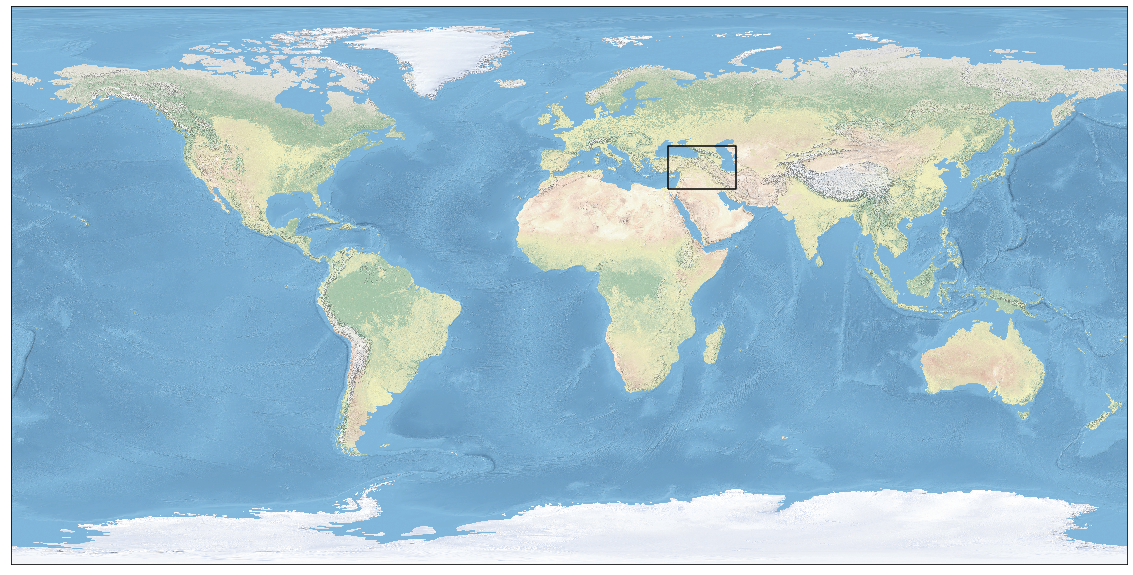

In [5]:
# Plot region outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny  maxx  maxy
11  32.0  31.0  54.0  45.0

# * * * * * * * * Glacier Analysis * * * * * * * *

## Open GLIMS 3 Largest Glaciers Data

In [7]:
# Open GLIMS three largest glacier outlines for this region.
glims_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [8]:
# Check if GLIMS glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
glims_df_len = len(glims_glaciers_df)
for x in range(glims_df_len):
    if glims_glaciers_df['glac_name'][x] == None:
        print("GLIMS glacier " + str(x) + " equals none")
        glims_glaciers_df.loc[x, 'glac_name'] = 'NONE'

In [9]:
glims_glaciers_df

region_no         glac_id     area  db_area  width  length  primeclass  \
0         12  G043100E43030N  37.4914  37.4991    0.0     0.0         0.0   
1         12  G043183E42984N  27.5349  27.5420    0.0     0.0         0.0   
2         12  G043748E42782N  23.9915  24.0045    0.0     0.0         0.0   
3         12  G042766E43151N  23.7692  23.7695    0.0     0.0         0.0   
4         12  G042506E43356N  21.4396  21.4354    0.0     0.0         0.0   

   min_elev  mean_elev  max_elev             src_date           glac_name  \
0       0.0        0.0       0.0  2014-08-03T07:49:37          Ulluchirak   
1       0.0        0.0       0.0  2014-08-03T07:49:37  Dikh-kotiu-bugoisy   
2       0.0        0.0       0.0  2014-08-03T07:49:37            Karaugom   
3       0.0        0.0       0.0  2014-08-03T07:49:37            Lekhziri   
4       0.0        0.0       0.0  2014-08-03T07:49:37         Kinchiroirt   

                                            geometry  
0  POLYGON Z ((43.066358 43.014609 0, 43.065336 4...  
1  POLYGON Z ((43.138395 43.013094 0, 43.138366 4...  
2  POLYGON Z ((43.761883 42.792313 0, 43.76203 42...  
3  POLYGON Z ((42.73108 43.181932 0, 42.731246 43...  
4  POLYGON Z ((42.5572 43.375623 0, 42.557648 43....

## Open RGI 3 Largest Glaciers Data

In [10]:
# Open RGI three largest glacier outlines for this region.
rgi_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_glaciers_df = gpd.read_file(rgi_glaciers_fn)

In [11]:
# Check if RGI glacier names are of the "NoneType" because can't print legends and such if they are
# If they are, set them to a string "NONE"
rgi_df_len = len(rgi_glaciers_df)
for x in range(rgi_df_len):
    if rgi_glaciers_df['Name'][x] == None:
        print("RGI glacier " + str(x) + " equals none")
        rgi_glaciers_df.loc[x, 'Name'] = 'NONE'

In [12]:
rgi_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-12.01005  G042748E43156N  20010915  -9999999  42.7479  43.1560   
1  RGI60-12.01252  G043084E43033N  20010915  -9999999  43.0840  43.0332   
2  RGI60-12.00611  G043751E42785N  19990818  -9999999  43.7512  42.7850   
3  RGI60-12.01061  G042519E43359N  20000912  -9999999  42.5192  43.3588   
4  RGI60-12.00080  G042422E43310N  20000912  -9999999  42.4219  43.3100   

  O1Region O2Region    Area  Zmin  ...  Aspect   Lmax  Status  Connect  Form  \
0       12        1  31.076  2168  ...     253  11554       0        0     0   
1       12        1  29.959  2143  ...      16  16992       0        0     0   
2       12        1  26.233  1890  ...     319  13205       0        0     0   
3       12        1  20.975  3233  ...      51   9410       0        0     0   
4       12        1  15.917  2668  ...     174   9839       0        0     0   

   TermType  Surging  Linkages                          Name  \
0         0        9         9                  SU5T09105247   
1         0        9         1  SU4G08007001 Bezengi Glacier   
2         0        9         9                  SU4G08008049   
3         0        9         9                  SU4G08005006   
4         0        3         9                  Bolshoy Azau   

                                            geometry  
0  POLYGON ((42.77902200000005 43.18760900000007,...  
1  POLYGON ((43.13495000000006 43.10652900000008,...  
2  POLYGON ((43.71724000000006 42.81615000000005,...  
3  POLYGON ((42.55329000000006 43.38119000000006,...  
4  POLYGON ((42.43052000000006 43.35431000000005,...  

[5 rows x 23 columns]

## Plot GLIMS Glaciers

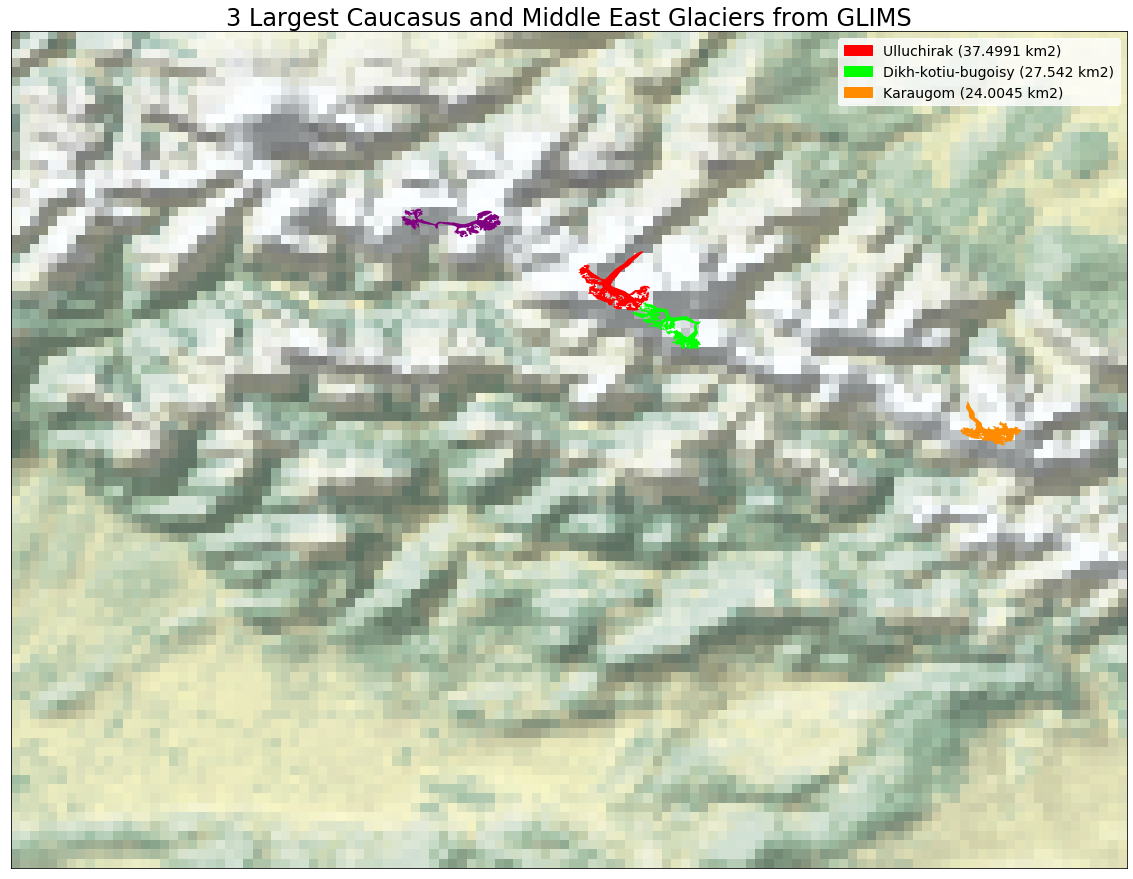

In [13]:
# Plot 3 largest glaciers on natural earth from GLIMS
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [glims_glaciers_df['glac_name'][0] + ' (' + str(glims_glaciers_df['db_area'][0]) + ' km2)',
                 glims_glaciers_df['glac_name'][1] + ' (' + str(glims_glaciers_df['db_area'][1]) + ' km2)',
                 glims_glaciers_df['glac_name'][2] + ' (' + str(glims_glaciers_df['db_area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom in
miny = 42.0
maxy = 43.5
minx = 42.0
maxx = 44.0
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
glims_glaciers_df.iloc[3:4].plot(ax=ax, color='purple')
ax.set_title('3 Largest ' + region_name + ' Glaciers from GLIMS', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Plot RGI Glaciers

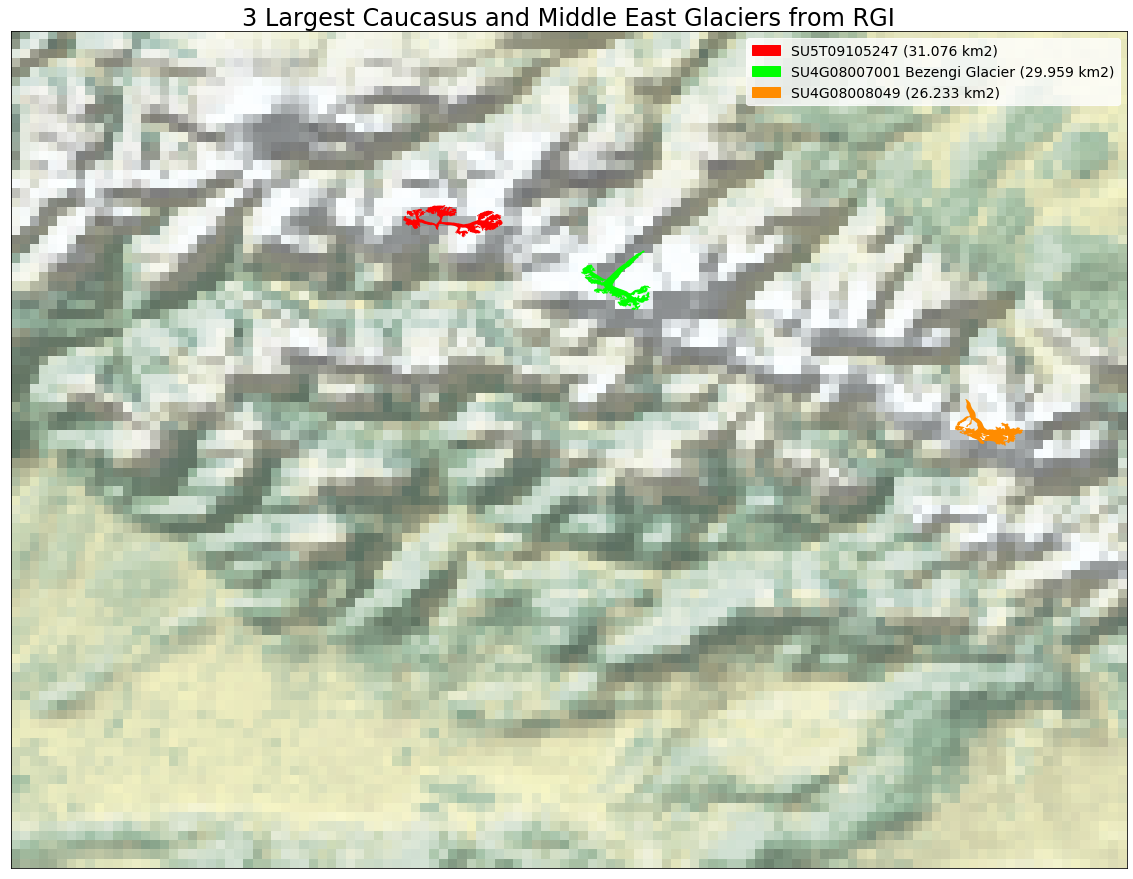

In [14]:
# Plot 3 largest glaciers on natural earth from RGI
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [rgi_glaciers_df['Name'][0] + ' (' + str(rgi_glaciers_df['Area'][0]) + ' km2)',
                 rgi_glaciers_df['Name'][1] + ' (' + str(rgi_glaciers_df['Area'][1]) + ' km2)',
                 rgi_glaciers_df['Name'][2] + ' (' + str(rgi_glaciers_df['Area'][2]) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom in
miny = 42.0
maxy = 43.5
minx = 42.0
maxx = 44.0
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from rgi dataframe
rgi_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
rgi_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
rgi_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers from RGI', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

## Compare Glaciers from GLIMS and RGI
Do they match? If yes, continue, if no, stop notebook and investigate

In [15]:
if (glims_glaciers_df['glac_name'][0] == rgi_glaciers_df['Name'][0] and 
    glims_glaciers_df['glac_name'][1] == rgi_glaciers_df['Name'][1] and 
    glims_glaciers_df['glac_name'][2] == rgi_glaciers_df['Name'][2]):
    print("They match!")
else:
    if handled != 1:
        # If this hasn't been handled, stop execution
        class StopExecution(Exception):
            def _render_traceback_(self):
                pass

        print("They do NOT Match! Stopping notebook.")
        raise StopExecution
    else:
        # If this has been handled, continue execution
        print("They do not match but this has been handled in the code below this section, so continue.")

They do not match but this has been handled in the code below this section, so continue.


## Create final shapefiles
This section creates and formats the final dataframe, plots it to make sure it looks ok, and saves it to a shapefile.

GLIMS and RGI do not exactly match

* The 1st larget in GLIMS (Ulluchirak) has a different name in RGI (Bezengi Glacier) and is 2nd largest. Heid and Kaab (2012) say Bezengi is largest in area. When I search Ulluchirak, I don't get any results but when I search Bezengi, I do. I think I will go with Bezengi as the name for this glacier.
* The 2nd largest in GLIMS (Dikh-kotiu-bugoisy - G043183E42984N) is broken up into, I think, 2 glaciers in RGI (RGI60-12.00521 and RGI60-12.00577). When I look at this in WGMS FOG browser, it's possilbe the left portion of the glacier is Dikh, but the right portion isn't named. Could it be Bugoisy and GLIMS put the two glacier together? RGI doesn't have names for them. Tielidze et al. (2017) does list this as a glacier but this paper has only been submitted and not published. But GLIMS lists Tielidze (2018) as the reference for that glacier. Kutuzov lists these two glaciers as Dich-su (left) and Ailama (right). **I think I will go with Dikh-kotiu-bugoisy but ask the correspondant about it.**
* The 3rd largest in GLIMS (Karaugom) is also the 3rd largest in RGI.
* The 1st largest in RGI is Lekhziri (SU5T09105247) but this is the 4th largest in GLIMS. The RGI outline includes a large chunk of ice to the north that GLIMS does not. This chunk looks like it belongs to Djankuat glacier (Tielidze et al., 2017). Also, Tieldize (2016) says that Lekhziri is third largest in Georgia and is cross shaped, so I think RGI is wrong.

Ok long story short, here's the 3 top glaciers I'm going to go with for Region 12:
* Bezengi Glacier (1st largest in GLIMS)
* Dikh-kotiu-bugoisy (2nd largest in GLIMS)
* Karaugom Glacier (3rd largest in GLIMS and RGI)

### Create final dataframe

In [16]:
# Set up the final dataframe that will be used when saving the final shapefiles
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_data_df = glims_glaciers_df.drop(['area', 'width', 'length', 
                                        'min_elev', 'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_data_df['reg_name'] = region_name

# Rename some columns
final_data_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                       'src_date': 'date'}, inplace=True)

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_data_df.drop([3, 4], inplace = True)

# Add RGI ID column
final_data_df['rgi_id'] = (rgi_glaciers_df['RGIId'][1], 'RGI60-12.00521, RGI60-12.00577', rgi_glaciers_df['RGIId'][2])

# Add area_src column that gets filled lower down
final_data_df['area_src'] = '-999'

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                               'area_km2', 'area_src', 'date', 'geometry']]

In [17]:
final_data_df

region_no                  reg_name           glac_name        glims_id  \
0         12  Caucasus and Middle East          Ulluchirak  G043100E43030N   
1         12  Caucasus and Middle East  Dikh-kotiu-bugoisy  G043183E42984N   
2         12  Caucasus and Middle East            Karaugom  G043748E42782N   

                           rgi_id  area_km2 area_src                 date  \
0                  RGI60-12.01252   37.4991     -999  2014-08-03T07:49:37   
1  RGI60-12.00521, RGI60-12.00577   27.5420     -999  2014-08-03T07:49:37   
2                  RGI60-12.00611   24.0045     -999  2014-08-03T07:49:37   

                                            geometry  
0  POLYGON Z ((43.066358 43.014609 0, 43.065336 4...  
1  POLYGON Z ((43.138395 43.013094 0, 43.138366 4...  
2  POLYGON Z ((43.761883 42.792313 0, 43.76203 42...

In [18]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are the same year, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
# Note because there were such differences in GLIMS and RGI, I did a manual comparison of dates and GLIMS is always
# the newest date, so going with the GLIMS areas.
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    #glims_date = glims_glaciers_df['src_date'][x][0:10].replace('-', '')
    #glims_year = glims_date[0:4]
    #print('glims date: ' + glims_date)
    #print('glims year: ' + glims_year)
    
    # Extract RGI date
    #rgi_date = rgi_glaciers_df['BgnDate'][x]
    #rgi_year = rgi_date[0:4]
    #print('rgi date: ' + rgi_date)
    #print('rgi year: ' + rgi_year)
    
    #if glims_year == rgi_year:
    #    # Average GLIMS and RGI areas
    #    area = np.average([glims_glaciers_df['db_area'][x], rgi_glaciers_df['Area'][x]])
    #    print('Averaging area: ' + str(area))
    #elif glims_year > rgi_year:
        # Use GLIMS area for the area
    area = glims_glaciers_df['db_area'][x]
    area_src = 'G'
    print('Using GLIMS area: ' + str(area))
    #elif rgi_year > glims_year:
        # Use RGI area for the area
    #    area = rgi_glaciers_df['Area'][x]
    #    print('Using RGI area: ' + str(area))
    #else:
    #    print("Error. Area could not be calculated.")
    
    print('')
    # Set the area in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_km2')] = area
    final_data_df.iloc[x, final_data_df.columns.get_loc('area_src')] = area_src
    
    # Clean the date format in the final dataframe
    final_data_df.iloc[x, final_data_df.columns.get_loc('date')] = glims_glaciers_df['src_date'][x][0:10]
    
# Clean up glacier names
final_data_df.iloc[0, final_data_df.columns.get_loc('glac_name')] = "Bezengi Glacier"
final_data_df.iloc[1, final_data_df.columns.get_loc('glac_name')] = "Dikh-Kotiu-Bugoisy Glacier"
final_data_df.iloc[2, final_data_df.columns.get_loc('glac_name')] = "Karaugom Glacier"

Using GLIMS area: 37.4991

Using GLIMS area: 27.542

Using GLIMS area: 24.0045



In [19]:
# Find the centroid of the glacier and add the lat/lon to the dataframe
centroidseries_gl = final_data_df['geometry'].centroid
    
final_data_df['cenlat'] = [centroidseries_gl.geometry.y[0], centroidseries_gl.geometry.y[1], 
                           centroidseries_gl.geometry.y[2]]
final_data_df['cenlon'] = [centroidseries_gl.geometry.x[0], centroidseries_gl.geometry.x[1], 
                           centroidseries_gl.geometry.x[2]]

# Reorder the columns of the dataframe
final_data_df = final_data_df[['region_no', 'reg_name', 'glac_name', 'glims_id', 'rgi_id', 
                                'area_km2', 'area_src', 'date', 'cenlat', 'cenlon', 'geometry']]

In [20]:
# Because only using the GLIMS data, set the RGI ID to N/A
final_data_df['rgi_id'] = 'N/A'

In [21]:
final_data_df

region_no                  reg_name                   glac_name  \
0         12  Caucasus and Middle East             Bezengi Glacier   
1         12  Caucasus and Middle East  Dikh-Kotiu-Bugoisy Glacier   
2         12  Caucasus and Middle East            Karaugom Glacier   

         glims_id rgi_id  area_km2 area_src        date     cenlat     cenlon  \
0  G043100E43030N    N/A   37.4991        G  2014-08-03  43.040486  43.083129   
1  G043183E42984N    N/A   27.5420        G  2014-08-03  42.972311  43.182522   
2  G043748E42782N    N/A   24.0045        G  2014-08-03  42.783871  43.754609   

                                            geometry  
0  POLYGON Z ((43.066358 43.014609 0, 43.065336 4...  
1  POLYGON Z ((43.138395 43.013094 0, 43.138366 4...  
2  POLYGON Z ((43.761883 42.792313 0, 43.76203 42...

### Plot final dataframe to check accuracy

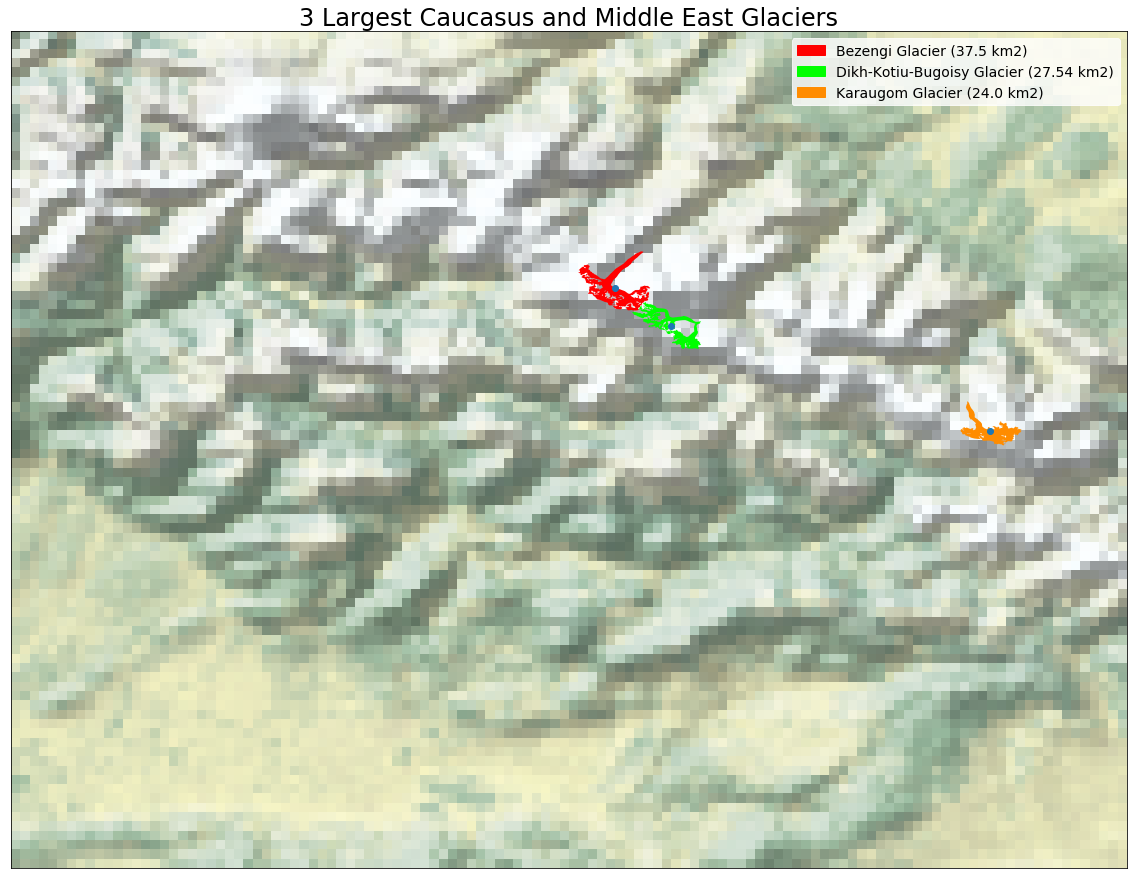

In [22]:
# Check that the geodataframe wasn't corrupted from these changes by plotting the data
# Plot 3 largest glaciers on natural earth from GLIMS
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_data_df['glac_name'][0] + ' (' + str(round(final_data_df['area_km2'][0], 2)) + ' km2)',
                 final_data_df['glac_name'][1] + ' (' + str(round(final_data_df['area_km2'][1], 2)) + ' km2)',
                 final_data_df['glac_name'][2] + ' (' + str(round(final_data_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom in
miny = 42.0
maxy = 43.5
minx = 42.0
maxx = 44.0
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
final_data_df.iloc[0:1].plot(ax=ax, color='red')
final_data_df.iloc[1:2].plot(ax=ax, color='lime')
final_data_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest ' + region_name + ' Glaciers', fontsize=24)

# Plot the center points of the glacier complexes
centroidseries_gl.plot(ax=ax)

# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Create shapefile from the final dataframe

In [38]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_fn) == False:
    # Create the shapefile
    final_data_fn = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_data_df.to_file(driver='ESRI Shapefile', filename=final_data_fn)
    
    # Zip up the shapefile
    zipfile_fn = ws.zipshp(final_data_fn, Delete=True)
    print("Creating zipfile: " + zipfile_fn)
else:
    print(zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-12-largest-glaciers.zip


# * * * * * * * * Ice Cap Analysis * * * * * * * *

In [24]:
# Open this regions ice caps from the exploded version
ice_caps_ex_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + region_number + "_laea.shp"
ice_caps_ex_df = gpd.read_file(ice_caps_ex_fn)

In [25]:
ice_caps_ex_df

id        area                                           geometry
0    11  153.431308  POLYGON ((43.312959 42.904061, 43.312771 42.90...
1     9  116.436625  POLYGON ((42.457875 43.301299, 42.457651 43.30...
2  1573   59.132297  POLYGON ((43.798557 42.767784, 43.798452 42.76...
3     6   58.054949  POLYGON ((42.856459 43.133462, 42.856414 43.13...
4     1   52.741497  POLYGON ((44.48342307945771 42.70768783254075,...
5  2053   22.499986  POLYGON ((42.64912435674368 43.1298869929593, ...
6     4   22.316573  POLYGON ((43.188543 43.040851, 43.188023 43.04...
7  2773   16.096299  POLYGON ((41.552928 43.277532, 41.552829 43.27...
8  3058   14.810747  POLYGON ((43.465751 42.961821, 43.465748 42.96...
9     2   14.692749  POLYGON ((43.624039 42.796083, 43.624095 42.79...

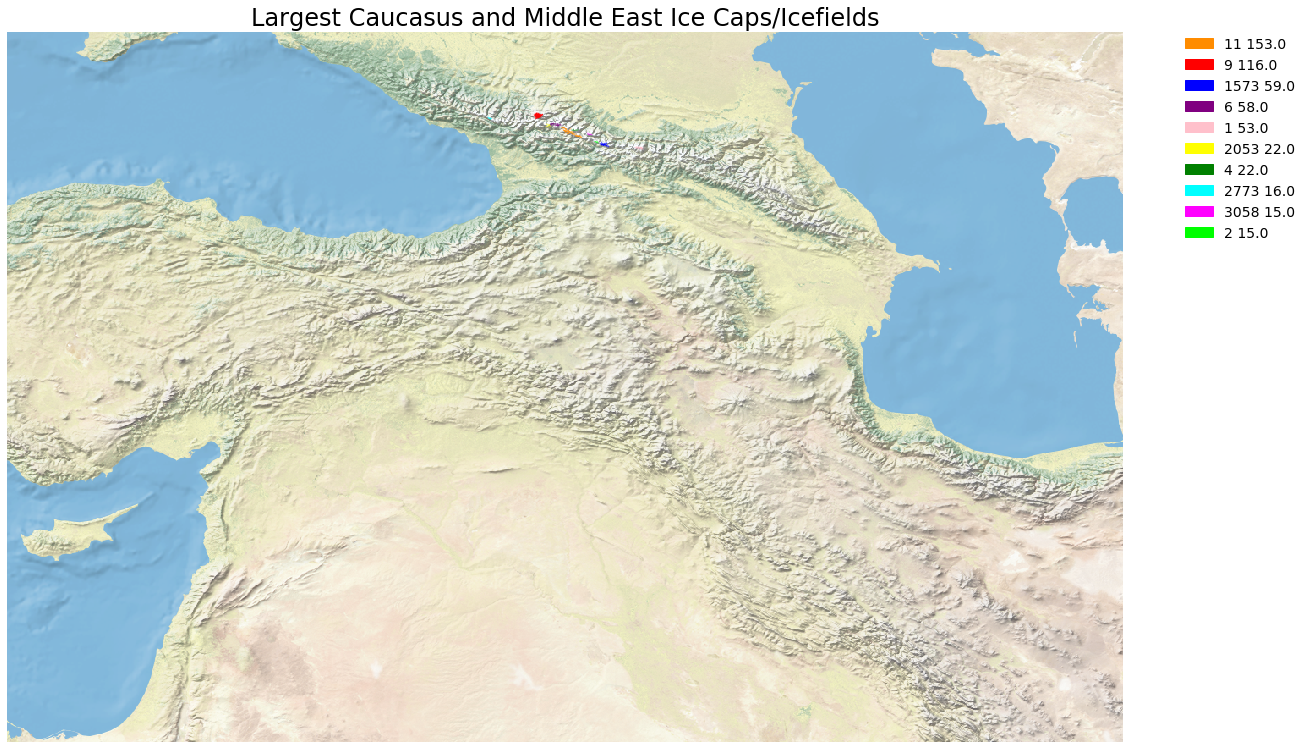

In [26]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['darkorange', 'red', 'blue', 'purple', 'pink', 'yellow', 'green', 'cyan', 'magenta', 'lime']
legend_labels = [str(ice_caps_ex_df['id'][0]) + ' ' + str(round(ice_caps_ex_df['area'][0])), 
                 str(ice_caps_ex_df['id'][1]) + ' ' + str(round(ice_caps_ex_df['area'][1])), 
                 str(ice_caps_ex_df['id'][2]) + ' ' + str(round(ice_caps_ex_df['area'][2])), 
                 str(ice_caps_ex_df['id'][3]) + ' ' + str(round(ice_caps_ex_df['area'][3])),
                 str(ice_caps_ex_df['id'][4]) + ' ' + str(round(ice_caps_ex_df['area'][4])),
                 str(ice_caps_ex_df['id'][5]) + ' ' + str(round(ice_caps_ex_df['area'][5])),
                 str(ice_caps_ex_df['id'][6]) + ' ' + str(round(ice_caps_ex_df['area'][6])),
                 str(ice_caps_ex_df['id'][7]) + ' ' + str(round(ice_caps_ex_df['area'][7])),
                 str(ice_caps_ex_df['id'][8]) + ' ' + str(round(ice_caps_ex_df['area'][8])),
                 str(ice_caps_ex_df['id'][9]) + ' ' + str(round(ice_caps_ex_df['area'][9]))]
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
ice_caps_ex_df.iloc[0:1].plot(ax=ax, color="darkorange")
ice_caps_ex_df.iloc[1:2].plot(ax=ax, color="red")
ice_caps_ex_df.iloc[2:3].plot(ax=ax, color="blue")
ice_caps_ex_df.iloc[3:4].plot(ax=ax, color="purple")
ice_caps_ex_df.iloc[4:5].plot(ax=ax, color="pink")
ice_caps_ex_df.iloc[5:6].plot(ax=ax, color="yellow")
ice_caps_ex_df.iloc[6:7].plot(ax=ax, color="green")
ice_caps_ex_df.iloc[7:8].plot(ax=ax, color="cyan")
ice_caps_ex_df.iloc[8:9].plot(ax=ax, color="magenta")
ice_caps_ex_df.iloc[9:10].plot(ax=ax, color="lime")
ax.set_title('Largest ' + region_name + ' Ice Caps/Icefields', fontsize=24)
ax.set_axis_off()

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

## Create Final Ice Catchment Data Frame

This ice catchment data frame will then be saved to a shapefile.

In [27]:
# Update and reorganize ice_caps_ex_df to create final df
# Drop uneeded columns
final_catchment_data_df = ice_caps_ex_df.drop(['id'], axis=1)

# Drop last 7 rows because only interested in the top 3 ice caps/icefields
final_catchment_data_df.drop([3, 4, 5, 6, 7, 8, 9], inplace = True)

# Add region_no column
final_catchment_data_df['region_no'] = region_number

# Add region_name column
final_catchment_data_df['reg_name'] = region_name

# Add catchment names
final_catchment_data_df['ic_name'] = ['Bezengi Glacier Complex', 
                                      'Elbrus Glacier Complex',
                                      'Karaugom Glacier Complex'] 

### Get ice catchment GLIMS IDs and measurement dates from a range of glacier outline dates.

In [28]:
# Open GLIMS shapefile with all of the glacier outlines
glims_all_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_all_glaciers_df = gpd.read_file(glims_all_glaciers_fn)

In [29]:
# The call to the pip function can take a couple of minutes to many hours to run depending on the complexity and size
# of the ice catchment outline. I set up the code to save the output to shapefiles that can be read in more quickly
# if desired. However, you can toggle whether you read the files or run the pip command with the following variable.
# Note that you must run the pip command the first time this code is run in order to create the shapefiles.
run_code = 0 # set to 0 to read from shapefiles, set to 1 to run pip command

# Get glaciers in the 1st largest glacier complex
if run_code == 1: # run pip command
    largest_ic_1_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[0:1].reset_index(drop=True), buffer_val=.001)
    largest_ic_1_glaciers = glims_all_glaciers_df.loc[largest_ic_1_mask]
    largest_ic_1_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-1st-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_1_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers = gpd.read_file(ic_1_glaciers_shape_fn)
    print("Reading file " + ic_1_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_1_min_date = largest_ic_1_glaciers['src_date'].min()[0:10]
largest_ic_1_max_date = largest_ic_1_glaciers['src_date'].max()[0:10]
print('1st largest start date: ' + largest_ic_1_min_date)
print('1st largest end date: ' + largest_ic_1_max_date)
print('')

# Get all glims ids that make up the 1st largest ice catchment
largest_ic_1_glims_ids = largest_ic_1_glaciers['glac_id']
for i in range(len(largest_ic_1_glims_ids)):
    if i == 0:
        all_largest_ic_1_ids = largest_ic_1_glims_ids[i]
    else:
        all_largest_ic_1_ids = all_largest_ic_1_ids + ', ' + largest_ic_1_glims_ids[i]

# Get glaciers in the 2nd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_2_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[1:2].reset_index(drop=True), buffer_val=.001)
    largest_ic_2_glaciers = glims_all_glaciers_df.loc[largest_ic_2_mask]
    largest_ic_2_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-2nd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_2_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers = gpd.read_file(ic_2_glaciers_shape_fn)
    print("Reading file " + ic_2_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_2_min_date = largest_ic_2_glaciers['src_date'].min()[0:10]
largest_ic_2_max_date = largest_ic_2_glaciers['src_date'].max()[0:10]
print('2nd largest start date: ' + largest_ic_2_min_date)
print('2nd largest end date: ' + largest_ic_2_max_date)
print('')

# Get all glims ids that make up the 2nd largest ice catchment
largest_ic_2_glims_ids = largest_ic_2_glaciers['glac_id']
for i in range(len(largest_ic_2_glims_ids)):
    if i == 0:
        all_largest_ic_2_ids = largest_ic_2_glims_ids[i]
    else:
        all_largest_ic_2_ids = all_largest_ic_2_ids + ', ' + largest_ic_2_glims_ids[i]


# Get glaciers in the 3rd largest glacier complex
if run_code == 1: # run pip command
    largest_ic_3_mask = ws.pip(glims_all_glaciers_df, ice_caps_ex_df.iloc[2:3].reset_index(drop=True), buffer_val=.001)
    largest_ic_3_glaciers = glims_all_glaciers_df.loc[largest_ic_3_mask]
    largest_ic_3_glaciers.reset_index(drop=True, inplace=True)
elif run_code == 0: # read saved shapefiles
    ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                        region_number + "-3rd-largest-ic-glacier-outlines.zip"
    with zipfile.ZipFile(ic_3_glaciers_zfn,"r") as zip_ref:
        zip_ref.extractall("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped")

    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-" + \
                                  region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers = gpd.read_file(ic_3_glaciers_shape_fn)
    print("Reading file " + ic_3_glaciers_shape_fn)

    # Clean up unzipped files to save disk space
    filelist = glob.glob("data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/*")
    for f in filelist:
        os.remove(f)
else:
    print("Incorrect value for the run_code variable. Must be 0 or 1.")

# Clean and print the minimum date and the maximum date
largest_ic_3_min_date = largest_ic_3_glaciers['src_date'].min()[0:10]
largest_ic_3_max_date = largest_ic_3_glaciers['src_date'].max()[0:10]
print('3rd largest start date: ' + largest_ic_3_min_date)
print('3rd largest end date: ' + largest_ic_3_max_date)
print('')

# Get all glims ids that make up the 3rd largest ice catchment
largest_ic_3_glims_ids = largest_ic_3_glaciers['glac_id']
for i in range(len(largest_ic_3_glims_ids)):
    if i == 0:
        all_largest_ic_3_ids = largest_ic_3_glims_ids[i]
    else:
        all_largest_ic_3_ids = all_largest_ic_3_ids + ', ' + largest_ic_3_glims_ids[i]

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-12-1st-largest-ic-glacier-outlines.shp
1st largest start date: 1960-01-01
1st largest end date: 2014-08-03

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-12-2nd-largest-ic-glacier-outlines.shp
2nd largest start date: 1960-01-01
2nd largest end date: 2014-08-03

Reading file data/glims/processed/ice-caps/largest/individual-glacier-outlines/unzipped/region-12-3rd-largest-ic-glacier-outlines.shp
3rd largest start date: 1999-08-18
3rd largest end date: 2014-08-28



In [30]:
# Find the centroid of the glacier complex and add the lat/lon to the dataframe
centroidseries = final_catchment_data_df['geometry'].centroid

In [31]:
# Add the dates to the dataframe
final_catchment_data_df['min_date'] = [largest_ic_1_min_date, largest_ic_2_min_date, largest_ic_3_min_date]

final_catchment_data_df['max_date'] = [largest_ic_1_max_date, largest_ic_2_max_date, largest_ic_3_max_date]

# Add lat/lon
final_catchment_data_df['cenlat'] = [centroidseries.geometry.y[0], centroidseries.geometry.y[1], 
                                     centroidseries.geometry.y[2]]
final_catchment_data_df['cenlon'] = [centroidseries.geometry.x[0], centroidseries.geometry.x[1], 
                                     centroidseries.geometry.x[2]]

# Reorder the columns
final_catchment_data_df = final_catchment_data_df[['region_no', 'reg_name', 'ic_name', 'area', 
                                                   'min_date', 'max_date', 'cenlat', 'cenlon', 'geometry']]
# Rename the area column
final_catchment_data_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_catchment_data_df = final_catchment_data_df.reset_index(drop=True)

In [32]:
final_catchment_data_df

region_no                  reg_name                   ic_name    area_km2  \
0        12  Caucasus and Middle East   Bezengi Glacier Complex  153.431308   
1        12  Caucasus and Middle East    Elbrus Glacier Complex  116.436625   
2        12  Caucasus and Middle East  Karaugom Glacier Complex   59.132297   

     min_date    max_date     cenlat     cenlon  \
0  1960-01-01  2014-08-03  43.014924  43.103356   
1  1960-01-01  2014-08-03  43.344908  42.462351   
2  1999-08-18  2014-08-28  42.773921  43.773006   

                                            geometry  
0  POLYGON ((43.312959 42.904061, 43.312771 42.90...  
1  POLYGON ((42.457875 43.301299, 42.457651 43.30...  
2  POLYGON ((43.798557 42.767784, 43.798452 42.76...

### Plot the final catchment dataframe to verify it looks correct

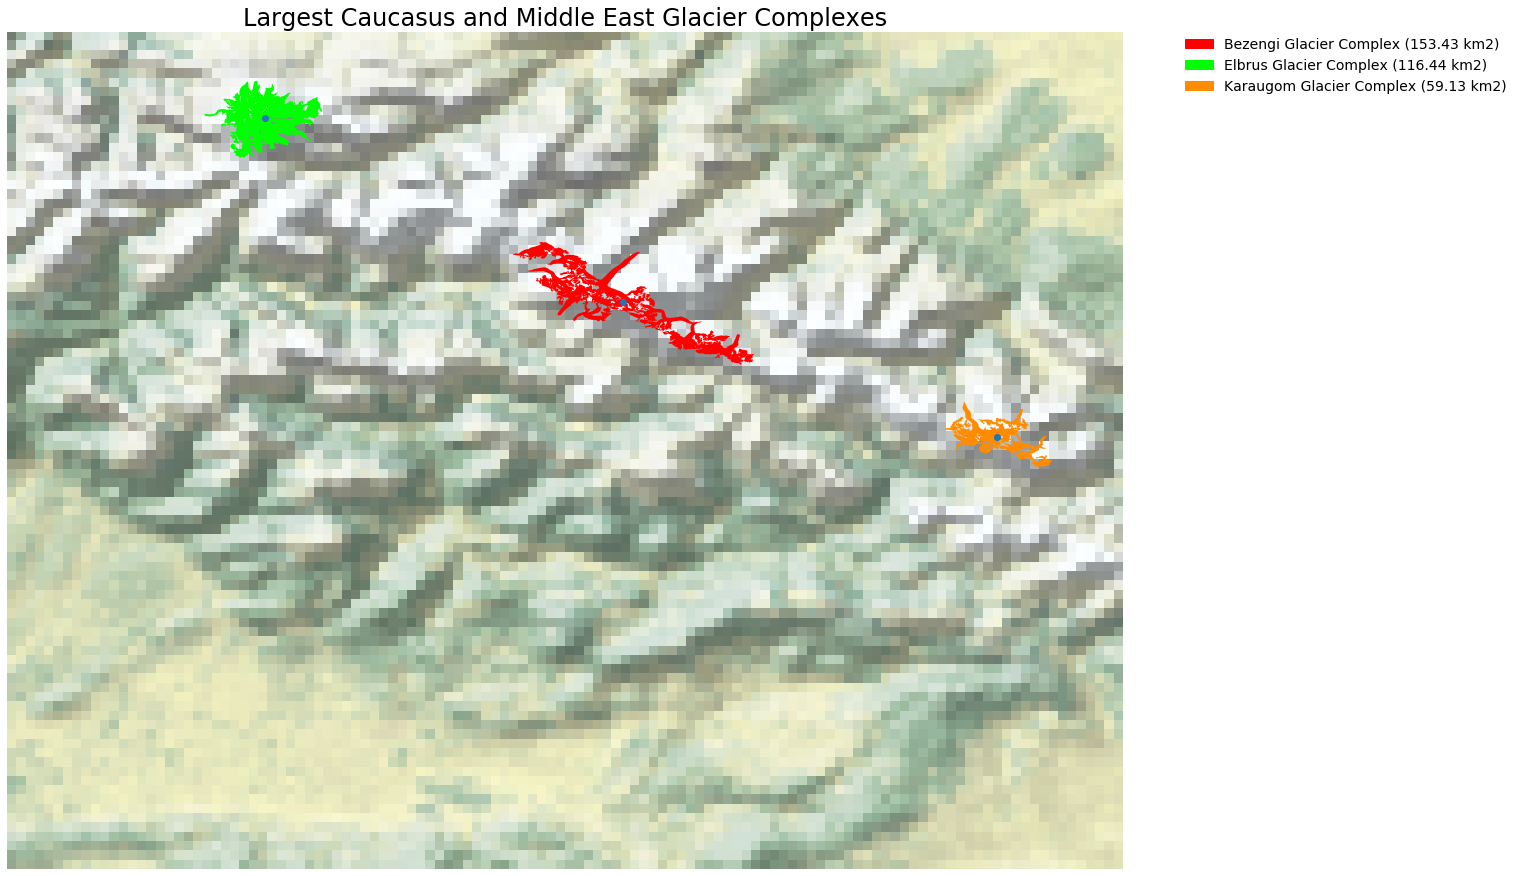

In [33]:
# Plot this regions ice caps in one frame
# Set up legend
legend_colors = ['red', 'lime', 'darkorange'] #, 'purple', 'pink', 'yellow']
legend_labels = [final_catchment_data_df['ic_name'][0] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][0], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][1] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][1], 2)) + ' km2)', 
                 final_catchment_data_df['ic_name'][2] + \
                 ' (' + str(round(final_catchment_data_df['area_km2'][2], 2)) + ' km2)'] 
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = region_outline.total_bounds
# Zoom in
miny = 42.0
maxy = 43.5
minx = 42.0
maxx = 44.0
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest
final_catchment_data_df.iloc[0:1].plot(ax=ax, color="red")
final_catchment_data_df.iloc[1:2].plot(ax=ax, color="lime")
final_catchment_data_df.iloc[2:3].plot(ax=ax, color="darkorange")
ax.set_title('Largest ' + region_name + ' Glacier Complexes', fontsize=24)
ax.set_axis_off()

# Plot the center points of the glacier complexes
centroidseries.plot(ax=ax)

# Add legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

plt.show()

### Save final catchment dataframe to a shapefile

In [37]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
catchment_zipfile_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(catchment_zipfile_fn) == False:
    # Create the shapefile
    final_catchment_data_fn = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_catchment_data_df.to_file(driver='ESRI Shapefile', filename=final_catchment_data_fn)
    
    # Zip up the shapefile
    catchment_zipfile_fn = ws.zipshp(final_catchment_data_fn, Delete=True)
    print("Creating zipfile: " + catchment_zipfile_fn)
else:
    print(catchment_zipfile_fn + " already extists")

Creating zipfile: data/final-dataset\region-12-largest-complexes.zip


In [35]:
# Save the glims ids to a text file because the text is too long to be saved to a shapefile
text_file_1st_fn = "data/final-dataset/region-" + region_number + "-1st-largest-glims-ids.txt"
if os.path.exists(text_file_1st_fn) == False:
    print("Creating text file: " + text_file_1st_fn)
    text_file = open(text_file_1st_fn, "w")
    n = text_file.write(all_largest_ic_1_ids)
    text_file.close()
else:
    print(text_file_1st_fn + " already extists")
    
text_file_2nd_fn = "data/final-dataset/region-" + region_number + "-2nd-largest-glims-ids.txt"
if os.path.exists(text_file_2nd_fn) == False:
    print("Creating text file: " + text_file_2nd_fn)
    text_file = open(text_file_2nd_fn, "w")
    n = text_file.write(all_largest_ic_2_ids)
    text_file.close()
else:
    print(text_file_2nd_fn + " already extists")
    
text_file_3rd_fn = "data/final-dataset/region-" + region_number + "-3rd-largest-glims-ids.txt"
if os.path.exists(text_file_3rd_fn) == False:
    print("Creating text file: " + text_file_3rd_fn)
    text_file = open(text_file_3rd_fn, "w")
    n = text_file.write(all_largest_ic_3_ids)
    text_file.close()
else:
    print(text_file_3rd_fn + " already extists")
    
# Save the glacier outline dataframes from the pip command to shapefiles for easier recall later because sometimes
# the pip command can take hours to run
ic_1_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-1st-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_1_glaciers_zfn) == False:
    # Create the shapefile
    ic_1_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-1st-largest-ic-glacier-outlines.shp"
    largest_ic_1_glaciers.to_file(driver='ESRI Shapefile', filename=ic_1_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_1_glaciers_zfn = ws.zipshp(ic_1_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_1_glaciers_zfn)
else:
    print(ic_1_glaciers_zfn + " already extists")
    
ic_2_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-2nd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_2_glaciers_zfn) == False:
    # Create the shapefile
    ic_2_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-2nd-largest-ic-glacier-outlines.shp"
    largest_ic_2_glaciers.to_file(driver='ESRI Shapefile', filename=ic_2_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_2_glaciers_zfn = ws.zipshp(ic_2_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_2_glaciers_zfn)
else:
    print(ic_2_glaciers_zfn + " already extists")
    
ic_3_glaciers_zfn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                    region_number + "-3rd-largest-ic-glacier-outlines.zip"
if os.path.exists(ic_3_glaciers_zfn) == False:
    # Create the shapefile
    ic_3_glaciers_shape_fn = "data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-" + \
                              region_number + "-3rd-largest-ic-glacier-outlines.shp"
    largest_ic_3_glaciers.to_file(driver='ESRI Shapefile', filename=ic_3_glaciers_shape_fn)
    
    # Zip up the shapefile
    ic_3_glaciers_zfn = ws.zipshp(ic_3_glaciers_shape_fn, Delete=True)
    print("Creating zipfile: " + ic_3_glaciers_zfn)
else:
    print(ic_3_glaciers_zfn + " already extists")

data/final-dataset/region-12-1st-largest-glims-ids.txt already extists
data/final-dataset/region-12-2nd-largest-glims-ids.txt already extists
data/final-dataset/region-12-3rd-largest-glims-ids.txt already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-12-1st-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-12-2nd-largest-ic-glacier-outlines.zip already extists
data/glims/processed/ice-caps/largest/individual-glacier-outlines/region-12-3rd-largest-ic-glacier-outlines.zip already extists


### Extra Stuff: Checking if pip function needs a buffer
Due to tiny differences in vertices computed from the explode method used to find ice catchments, the pip function doesn't always return all glaceris that should be in that outline. This section analyses what size buffer is needed to capture all glacier outlines that reside in an ice catchment outline.

All 3 largest ice catchments needed a buffer. A buffer value of .001 was optimal. The buffer value was added to the pip call in the code above.

Even after the correct buffer is found, the area from the sum of all the glacier outlines in an ice catchment versus the area calculated from the exploded ice catchment didn't exactly match - the area from the sum is larger. This is due to an issue in the orginal GLIMS database where some glacier outlines are included twice but get different glacier ids so they appear to be different outlines even when they are not. So when the sum is calculated those glaciers are getting counted twice. Verified this by using a script written by Bruce Raup called find_overlapping_entities.py. See 9-analyze-region-11-central-europe.ipynb for examples.

In [36]:
# Stop execution here. Run extra stuff manually if you want to run this code
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook.")
raise StopExecution

Stopping notebook.


#### Check 1st largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[0:1].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_1_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
print('Area from sum: ', largest_ic_1_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_1 = final_catchment_data_df['area_km2'].iloc[0:1][0] - largest_ic_1_glaciers['db_area'].sum()
if (abs(area_diff_1)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_1))
    match1 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_1))
    match1 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .001
if match1 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_1_explode_outline = ice_caps_ex_df.iloc[0:1].reset_index(drop=True)
    largest_ic_1_mask_test = glims_all_glaciers_df.buffer(0).within(ic_1_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_1_glaciers_test = glims_all_glaciers_df.loc[largest_ic_1_mask_test]
    largest_ic_1_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_1_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[0:1][0])
    print('Area from sum: ', largest_ic_1_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_1_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[0:1].boundary.plot(ax=ax, color='blue')

#### Check 2nd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[1:2].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_2_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
print('Area from sum: ', largest_ic_2_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_2 = final_catchment_data_df['area_km2'].iloc[1:2][1] - largest_ic_2_glaciers['db_area'].sum()
if (abs(area_diff_2)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_2))
    match2 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_2))
    match2 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .001
if match2 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_2_explode_outline = ice_caps_ex_df.iloc[1:2].reset_index(drop=True)
    largest_ic_2_mask_test = glims_all_glaciers_df.buffer(0).within(ic_2_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_2_glaciers_test = glims_all_glaciers_df.loc[largest_ic_2_mask_test]
    largest_ic_2_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_2_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    #acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[1:2][1])
    print('Area from sum: ', largest_ic_2_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_2_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[1:2].boundary.plot(ax=ax, color='blue')

#### Check 3rd largest

In [ ]:
# Plot the catchment outline
final_catchment_data_df.iloc[2:3].boundary.plot()

# Plot the outlines acquired from pip function
largest_ic_3_glaciers.boundary.plot()

# Compare area calculated from the catchment outline and the sum of the individual outlines 
# acquired from pip function
print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
print('Area from sum: ', largest_ic_3_glaciers['db_area'].sum())

# Calculate the difference and print a message based on the magnitude of the difference
area_diff_3 = final_catchment_data_df['area_km2'].iloc[2:3][2] - largest_ic_3_glaciers['db_area'].sum()
if (abs(area_diff_3)) <= .001:
    print("Areas match well! Area difference: ", abs(area_diff_3))
    match3 = 1
else:
    print("*** Areas do not match well. May need to add a buffer. Area difference:", abs(area_diff_3))
    match3 = 0

In [ ]:
# If the areas do not match need to try different buffer values to get best match
buffer_val = .001
if match3 == 0:
    # Trying a buffer on the within function to see if it captures more of the galcier outliness
    ic_3_explode_outline = ice_caps_ex_df.iloc[2:3].reset_index(drop=True)
    largest_ic_3_mask_test = glims_all_glaciers_df.buffer(0).within(ic_3_explode_outline.loc[0, 'geometry'].
                                                                    buffer(buffer_val))
    largest_ic_3_glaciers_test = glims_all_glaciers_df.loc[largest_ic_3_mask_test]
    largest_ic_3_glaciers_test.reset_index(drop=True, inplace=True)
    
    # Plot the new buffered glacier outlines
    largest_ic_3_glaciers_test.boundary.plot()
    
    # Compare area calculated from the catchment outline and the sum of the individual outlines 
    # acquired from pip function
    print('Area from catchment outline: ', final_catchment_data_df['area_km2'].iloc[2:3][2])
    print('Area from sum: ', largest_ic_3_glaciers_test['db_area'].sum())
    
    # Plot the new buffered glacier outlines against the ice catchment outline
    fig, ax = plt.subplots(figsize=(5, 5))
    largest_ic_3_glaciers_test.boundary.plot(ax=ax, color='red')
    final_catchment_data_df.iloc[2:3].boundary.plot(ax=ax, color='blue')